# Model Evaluation NoteBook

## Setup Imports and Load Test Dataset

In [1]:
# Import standard libraries
import torch
from torchvision import transforms, datasets

TEST_PATH = "./asl_alphabet_test/asl_alphabet_test"

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the test dataset using ImageFolder
test_dataset = datasets.ImageFolder(TEST_PATH, transform=test_transforms)

print(f"Loaded test dataset with {len(test_dataset)} images across {len(test_dataset.classes)} classes.")

Loaded test dataset with 17428 images across 29 classes.


## Load Best Model and Setup Evaluation

Initialize the model with the correct input shape and number of classes, loads the best model checkpoint, and creates a DataLoader for the test dataset.

In [2]:
from classifier import ASLModel  

# Set device to GPU if available, else CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print("Device:", device)

# Determine number of classes from the test dataset loaded in Cell 1
num_classes = len(test_dataset.classes)

# Define input shape based on the transformations applied in Cell 1 (e.g., 3 channels, 224x224 pixels)
input_shape = (3, 224, 224)

# Initialize the model instance with the input_shape parameter
model = ASLModel(num_classes=num_classes, input_shape=input_shape)

# Load the best model checkpoint
checkpoint_path = "ASL_net.pth" 
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Model loaded and ready for evaluation.")

Device: cuda
Model loaded and ready for evaluation.


## Evaluate Model on Test Dataset

Iterate over the test dataset to compute predictions, calculates the overall accuracy, generates a confusion matrix, and prints a detailed classification report. It also visualizes the confusion matrix.

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

all_preds = []
all_labels = []

model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    # Using tqdm for a progress bar
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Evaluating: 100%|██████████| 545/545 [01:57<00:00,  4.64it/s]


In [4]:
# Compute overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


# Display classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

Test Accuracy: 99.47%
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       601
           B       1.00      1.00      1.00       601
           C       1.00      1.00      1.00       601
           D       1.00      1.00      1.00       601
           E       1.00      0.99      0.99       601
           F       1.00      0.99      0.99       601
           G       0.99      1.00      1.00       601
           H       1.00      1.00      1.00       601
           I       0.99      1.00      0.99       601
           J       0.99      1.00      1.00       601
           K       1.00      1.00      1.00       601
           L       1.00      1.00      1.00       601
           M       1.00      0.98      0.99       601
           N       0.98      1.00      0.99       601
           O       1.00      1.00      1.00       601
           P       1.00      1.00      1.00       601
           Q       1.00      1.00   

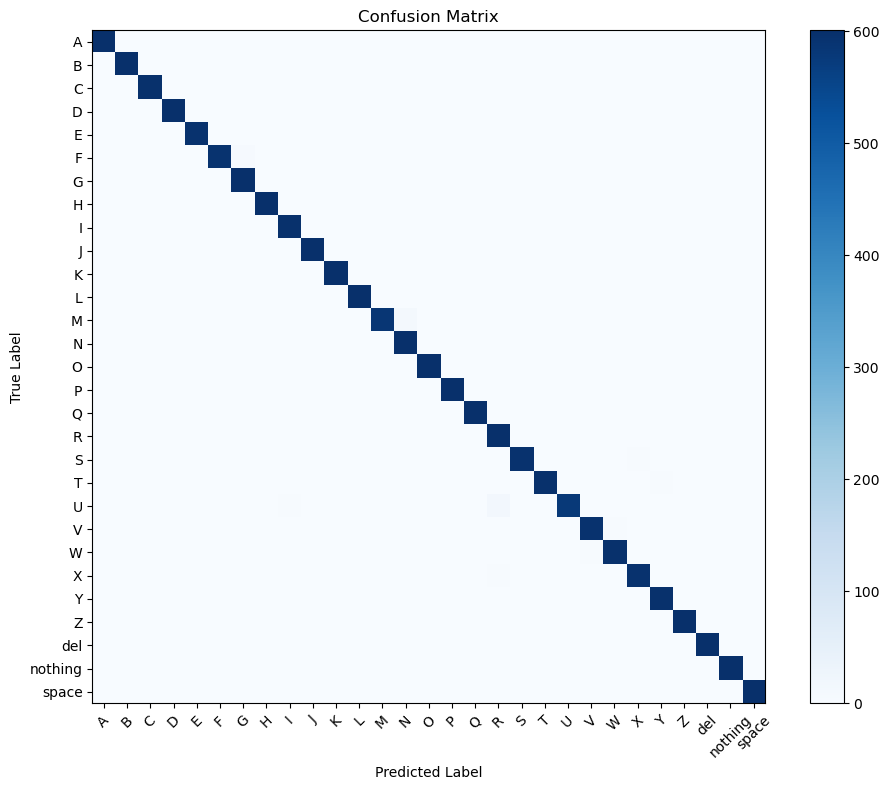

In [5]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(test_dataset.classes))
plt.xticks(tick_marks, test_dataset.classes, rotation=45)
plt.yticks(tick_marks, test_dataset.classes)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

## Analyze Misclassified Examples and Per-Class Accuracy

Identify misclassified examples, displays a selection of them with their true and predicted labels, and calculates the per-class accuracy. It visualizes the per-class accuracy as a bar chart, which is useful for identifying specific classes where the model might be underperforming.

Total misclassified examples: 92


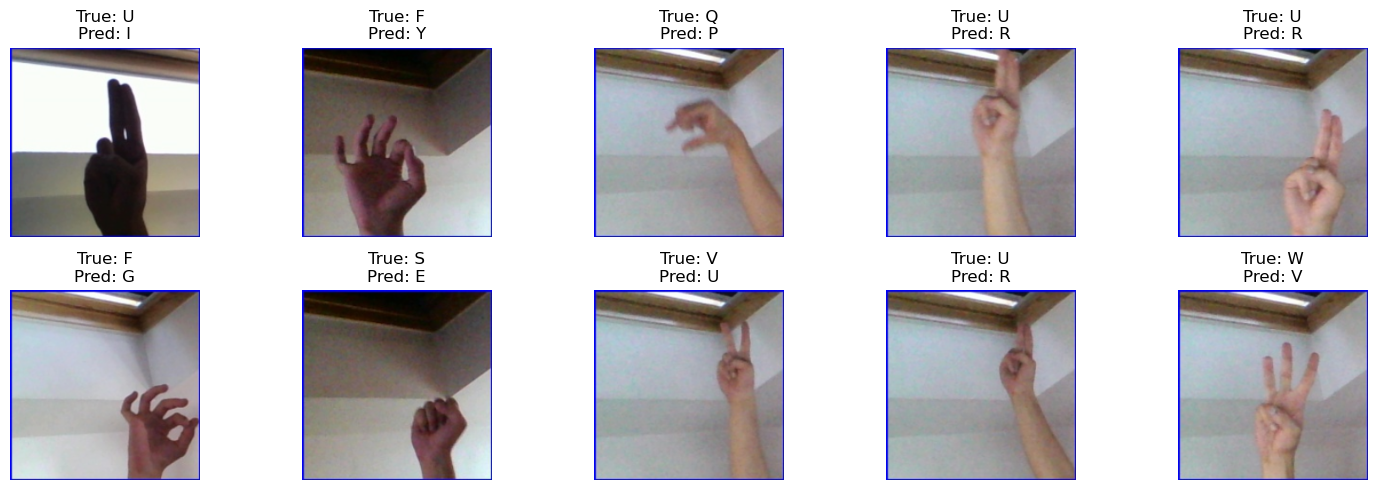

In [6]:
# Notebook Cell 5: Analyze Misclassified Examples and Per-Class Accuracy

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Ensure predictions and labels are computed (from Cell 3)
try:
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]
except NameError:
    raise Exception("Please run the evaluation cell (Cell 3) first to compute all_preds and all_labels.")

print(f"Total misclassified examples: {len(misclassified_indices)}")

# Display a few misclassified examples
num_misclassified = min(10, len(misclassified_indices))
if num_misclassified > 0:
    sample_indices = np.random.choice(misclassified_indices, num_misclassified, replace=False)
    
    plt.figure(figsize=(15, 5))
    for idx, mis_idx in enumerate(sample_indices):
        img, label = test_dataset[mis_idx]
        pred_label = all_preds[mis_idx]
        
        plt.subplot(2, 5, idx+1)
        # Convert tensor to numpy array and undo normalization
        img_np = img.cpu().permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        plt.imshow(img_np)
        plt.title(f"True: {test_dataset.classes[label]}\nPred: {test_dataset.classes[pred_label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified examples to display.")


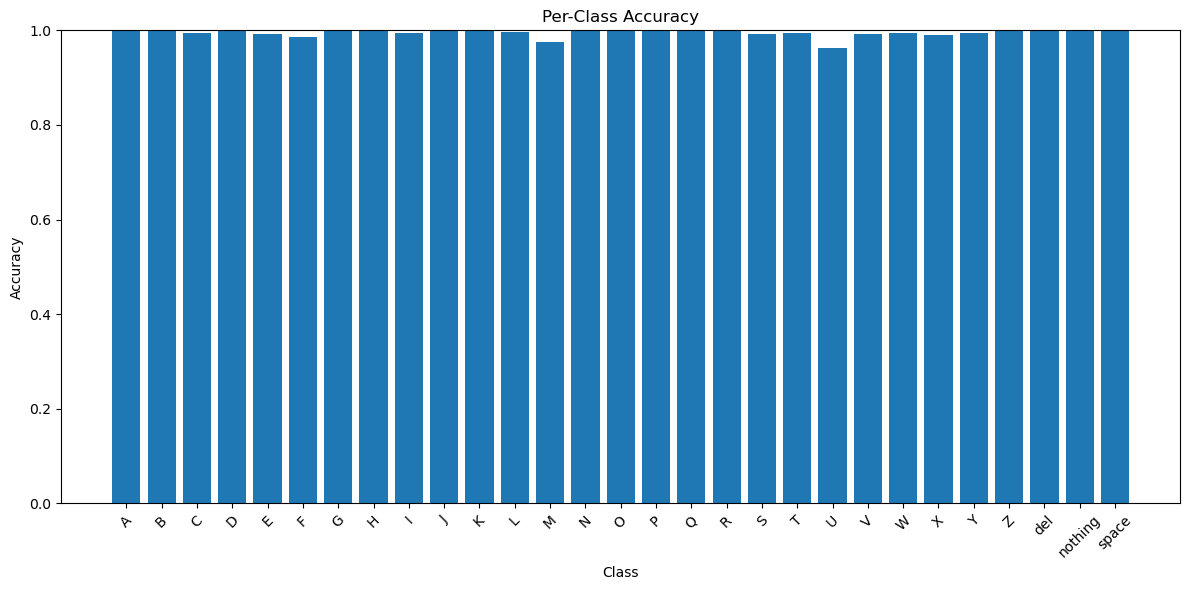

In [7]:
# Calculate per-class accuracy
class_correct = defaultdict(int)
class_total = defaultdict(int)
for true, pred in zip(all_labels, all_preds):
    if true == pred:
        class_correct[true] += 1
    class_total[true] += 1

classes = test_dataset.classes
class_accuracies = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(len(classes))]

plt.figure(figsize=(12, 6))
plt.bar(classes, class_accuracies)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [8]:
# Print per-class accuracy as a list in percentage
print("Per-Class Accuracy (in %):")
accuracy_list = []
for cls, acc in zip(classes, class_accuracies):
    percentage = acc * 100
    accuracy_list.append(percentage)
    print(f"{cls}: {percentage:.2f}%")

Per-Class Accuracy (in %):
A: 99.83%
B: 100.00%
C: 99.50%
D: 100.00%
E: 99.17%
F: 98.67%
G: 100.00%
H: 100.00%
I: 99.50%
J: 100.00%
K: 99.83%
L: 99.67%
M: 97.50%
N: 99.83%
O: 100.00%
P: 100.00%
Q: 99.83%
R: 99.83%
S: 99.17%
T: 99.33%
U: 96.17%
V: 99.17%
W: 99.33%
X: 99.00%
Y: 99.50%
Z: 100.00%
del: 99.83%
nothing: 100.00%
space: 100.00%


## Analyze Prediction Confidence

Compute softmax probabilities for each prediction, then separates and plots the confidence scores for correct versus incorrect predictions. It uses histograms to help visualize how confident the model is in its predictions.

In [9]:
# Notebook Cell 7: Confidence Histogram Analysis

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Lists to store confidence scores
correct_confidences = []
incorrect_confidences = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Analyzing Confidence"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        confidences, preds = torch.max(probabilities, 1)
        for i in range(len(labels)):
            if preds[i] == labels[i]:
                correct_confidences.append(confidences[i].item())
            else:
                incorrect_confidences.append(confidences[i].item())

Analyzing Confidence: 100%|██████████| 545/545 [01:45<00:00,  5.17it/s]


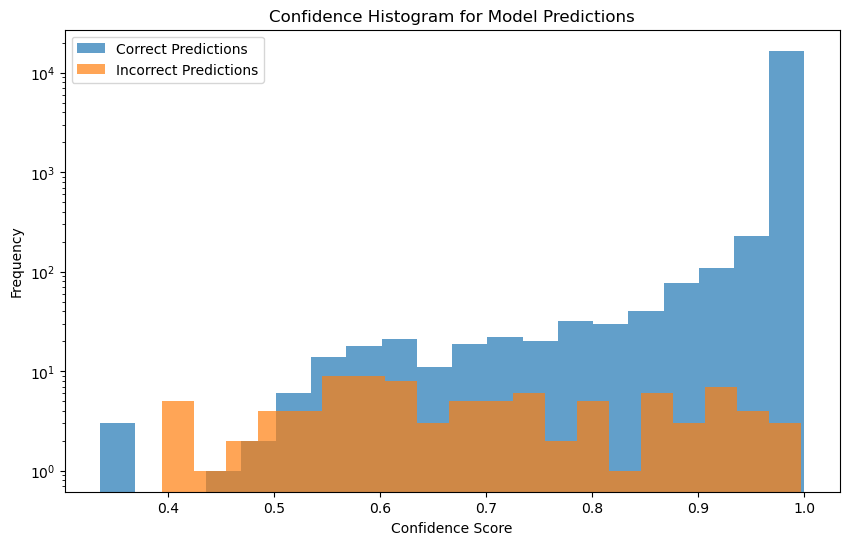

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(correct_confidences, bins=20, alpha=0.7, label="Correct Predictions")
plt.hist(incorrect_confidences, bins=20, alpha=0.7, label="Incorrect Predictions")
plt.yscale("log")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Confidence Histogram for Model Predictions")
plt.legend()
plt.show()